In [54]:
import xarray as xr
import os
# Need to use xbatcher from: https://github.com/arbennett/xbatcher/tree/develop
# python -m pip install git+https://github.com/arbennett/xbatcher/tree/develop.git (Doesn't work)
import xbatcher as xb
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
from parflow.tools.io import read_pfb

# Setup the paths to the test case

In [ ]:
BASE_DIR = '/Users/laura/Documents/Research/NAIRR/test_box1_conus2_2005WY'

#list of the static files to use
parameter_list= ['slope_x', 'slope_y', 'pf_indicator']

#get the domain sizes from one of the 3D parameter fields (this assumes that all will have the same shape I don't have a check for that built in, also assumes you will correctly pick a 3D one and not a 2D one)
size_test=read_pfb(f'{BASE_DIR}/static/{parameter_list[2]}.pfb')
print(size_test.shape)
X_EXTENT = size_test.shape[2] ## Note need to check if I have the X and Y extents in the right order -- to do this do a new clip but not with a square domain
Y_EXTENT = size_test.shape[1]
Z_EXTENT = size_test.shape[0]
T_EXTENT = 1 #This is just for the dummy data for sampling so keep T_EXTENT to 1

#Set the the patch size/overlap to be used for sampling
PATCH_SIZE = 16
PATCH_OVERLAP = 4

# Create a dummy dataset that will be used to pull indices for reading subsets of the data
dummy_data = xr.Dataset().assign_coords({
    'time': np.arange(T_EXTENT),
    'z': np.arange(Z_EXTENT),
    'y': np.arange(Y_EXTENT),
    'x': np.arange(X_EXTENT)
})
print(dummy_data)


(64, 64, 10)
<xarray.Dataset> Size: 1kB
Dimensions:  (time: 1, z: 64, y: 64, x: 10)
Coordinates:
  * time     (time) int64 8B 0
  * z        (z) int64 512B 0 1 2 3 4 5 6 7 8 9 ... 55 56 57 58 59 60 61 62 63
  * y        (y) int64 512B 0 1 2 3 4 5 6 7 8 9 ... 55 56 57 58 59 60 61 62 63
  * x        (x) int64 80B 0 1 2 3 4 5 6 7 8 9
Data variables:
    *empty*


## The batch generator create all of the sets of indices we need to sample the full dataset

In [56]:
PATCH_SIZE = 20
PATCH_OVERLAP = 4

bgen = xb.BatchGenerator(
    dummy_data,
    input_dims={'x': PATCH_SIZE, 'y': PATCH_SIZE, 'time': 1},
    input_overlap={'x': PATCH_OVERLAP, 'y': PATCH_OVERLAP},
    return_partial=True,
    shuffle=True,
)

# Now you can see this pulls samples from the dummy data
# Normally you would loop over this, but I can just do 
# this to grab the first sample
sample_indices = next(iter(bgen))

# Pulling the indices we need
time_index = sample_indices['time'].values[0]
x_min, x_max = sample_indices['x'].values[[0, -1]]
y_min, y_max = sample_indices['y'].values[[0, -1]]

# Setting up the keys dictionary
patch_keys = {
    'x': {'start': x_min, 'stop': x_max+1},
    'y': {'start': y_min, 'stop': y_max+1},
}

print(patch_keys)


{'x': {'start': np.int64(16), 'stop': np.int64(36)}, 'y': {'start': np.int64(16), 'stop': np.int64(36)}}


### Getting the pressure files

In [60]:
# Get Pressure files
pressure_files = sorted(glob(f'{BASE_DIR}/transient/pressure*.pfb'))
pressure_files = {
    't': pressure_files[0:-1],
    't+1': pressure_files[1:]
}

# Construct the state data:
file_to_read = pressure_files['t'][time_index]
state_data = read_pfb(file_to_read, keys=patch_keys)

# Construct the target data:
file_to_read_target = pressure_files['t+1'][time_index]
target_data = read_pfb(file_to_read_target, keys=patch_keys)

# Forcings and targets now have dims
# (layers, y, x)
print(state_data.shape, target_data.shape)


(10, 20, 20) (10, 20, 20)


### Pulling the static field data

In [61]:
parameter_data = []
for parameter in parameter_list:
    print(file_name)
    file_name=f'{BASE_DIR}/static/{parameter}.pfb'
    parameter_data.append(read_pfb(file_name, keys=patch_keys))

# Concatenate the parameter data together
# End result is a dims of (n_parameters, y, x)
parameter_data = np.concatenate(parameter_data, axis=0)
parameter_data.shape

/Users/laura/Documents/Research/NAIRR/test_rectangle1_conus2_2005WY/static/pf_indicator.pfb
/Users/laura/Documents/Research/NAIRR/test_rectangle1_conus2_2005WY/static/slope_x.pfb
/Users/laura/Documents/Research/NAIRR/test_rectangle1_conus2_2005WY/static/slope_y.pfb


(12, 20, 20)

### Random testing stuff don't need

(10, 74, 64)
(10, 74, 64)


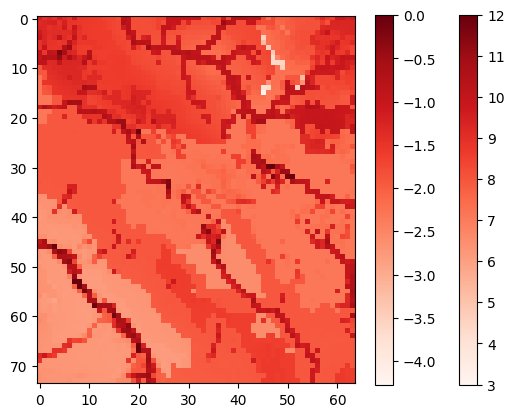

In [53]:
#Test plotting of static input data to make sure everything is lining up okay 
var='pf_indicator'
file_name=f'{BASE_DIR}/static/{var}.pfb'
test = read_pfb(file_name)
print(test.shape)
ni=test.shape[2]
nj=test.shape[1]
layer=9

cmap1 = "Reds"
sub_flip = np.zeros((1, nj, ni))
sub_flip[0, :, :] = test[layer, :, :]
sub_flip = np.flip(sub_flip, 1)

plt.imshow(sub_flip[0, :, :], cmap=cmap1)
plt.colorbar()

# Test plotting of transient input data 
var='pressure'
file_name=f'{BASE_DIR}/transient/{var}.00005.pfb'
test = read_pfb(file_name)
print(test.shape)
ni=test.shape[2]
nj=test.shape[1]
layer=9

cmap1 = "Reds"
sub_flip = np.zeros((1, nj, ni))
sub_flip[0, :, :] = test[layer, :, :]
sub_flip = np.flip(sub_flip, 1)

plt.imshow(sub_flip[0, :, :], cmap=cmap1)
plt.colorbar()